# Filter method from https://towardsdatascience.com/feature-selection-with-pandas-e3690ad8504b

In [1]:
import pandas as pd
import numpy as np

import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
%matplotlib inline
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.linear_model import LinearRegression
from sklearn.feature_selection import RFE
from sklearn.linear_model import RidgeCV, LassoCV, Ridge, Lasso
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import make_pipeline

from skrebate import ReliefF

/Users/gioelepozzi/miniconda3/lib/python3.7/site-packages/sklearn/externals/joblib/__init__.py:15: FutureWarning: sklearn.externals.joblib is deprecated in 0.21 and will be removed in 0.23. Please import this functionality directly from joblib, which can be installed with: pip install joblib. If this warning is raised when loading pickled models, you may need to re-serialize those models with scikit-learn 0.21+.
  warnings.warn(msg, category=FutureWarning)


In [2]:
static_features_dir = '/Users/gioelepozzi/Desktop/data/features_thesis/static_features.csv'
static_features_df = pd.read_csv(static_features_dir)

VA_mean_dir = '/Users/gioelepozzi/Desktop/data/annotations_thesis/static_annotations.csv'
VA_mean_df = pd.read_csv(VA_mean_dir)
V_mean_df = VA_mean_df[['music_ID','Valence(mean)']]

static_v_mean = pd.merge(static_features_df, V_mean_df, on=['music_ID'])

In [3]:
X = static_v_mean.drop(columns=['music_ID','Valence(mean)']) # feature matrix
y = static_v_mean['Valence(mean)'] # target variable

static_v_mean.head()

music_ID     tempo  total_beats  average_beats  chroma_stft_mean  \
0         1  0.473684     0.082270       0.239042          0.425812   
1         4  0.613003     0.069168       0.180548          0.707388   
2         5  0.515235     0.727782       0.931980          0.747134   
3         6  0.561404     0.075593       0.197295          0.807127   
4         7  0.401914     0.052441       0.173107          0.403568   

   chroma_stft_std  chroma_stft_var  chroma_cq_mean  chroma_cq_std  \
0         0.684119         0.645955        0.323742       0.879110   
1         0.566089         0.522710        0.462983       0.691251   
2         0.603002         0.560725        0.316611       0.874086   
3         0.225805         0.194932        0.152991       0.772858   
4         0.749863         0.716738        0.794024       0.354396   

   chroma_cq_var  ...  skewMFCC[10]  meanMFCC[11]  stdMFCC[11]  \
0       0.855313  ...      0.466125      0.826533     0.464964   
1       0.643463  ...      0.386633      0.657950     0.402376   
2       0.849443  ...      0.571215      0.514926     0.426316   
3       0.733550  ...      0.480139      0.623050     0.473834   
4       0.303165  ...      0.533062      0.294392     0.384103   

   medianMFCC[11]  kurtMFCC[11]  skewMFCC[11]  mfcc_delta_mean  \
0        0.835492      0.177943      0.476947         0.391541   
1        0.650071      0.291332      0.523016         0.532553   
2        0.521411      0.206211      0.491943         0.243234   
3        0.615538      0.108991      0.579753         0.148765   
4        0.273034      0.087832      0.614523         0.378576   

   mfcc_delta_std  mfcc_delta_var  Valence(mean)  
0        0.557548        0.389326         0.5750  
1        0.621624        0.461231         0.2875  
2        0.711493        0.571514         0.2000  
3        0.650398        0.495343         0.3500  
4        0.334149        0.182426         0.7250  

[5 rows x 110 columns]

# Pearson Correlation

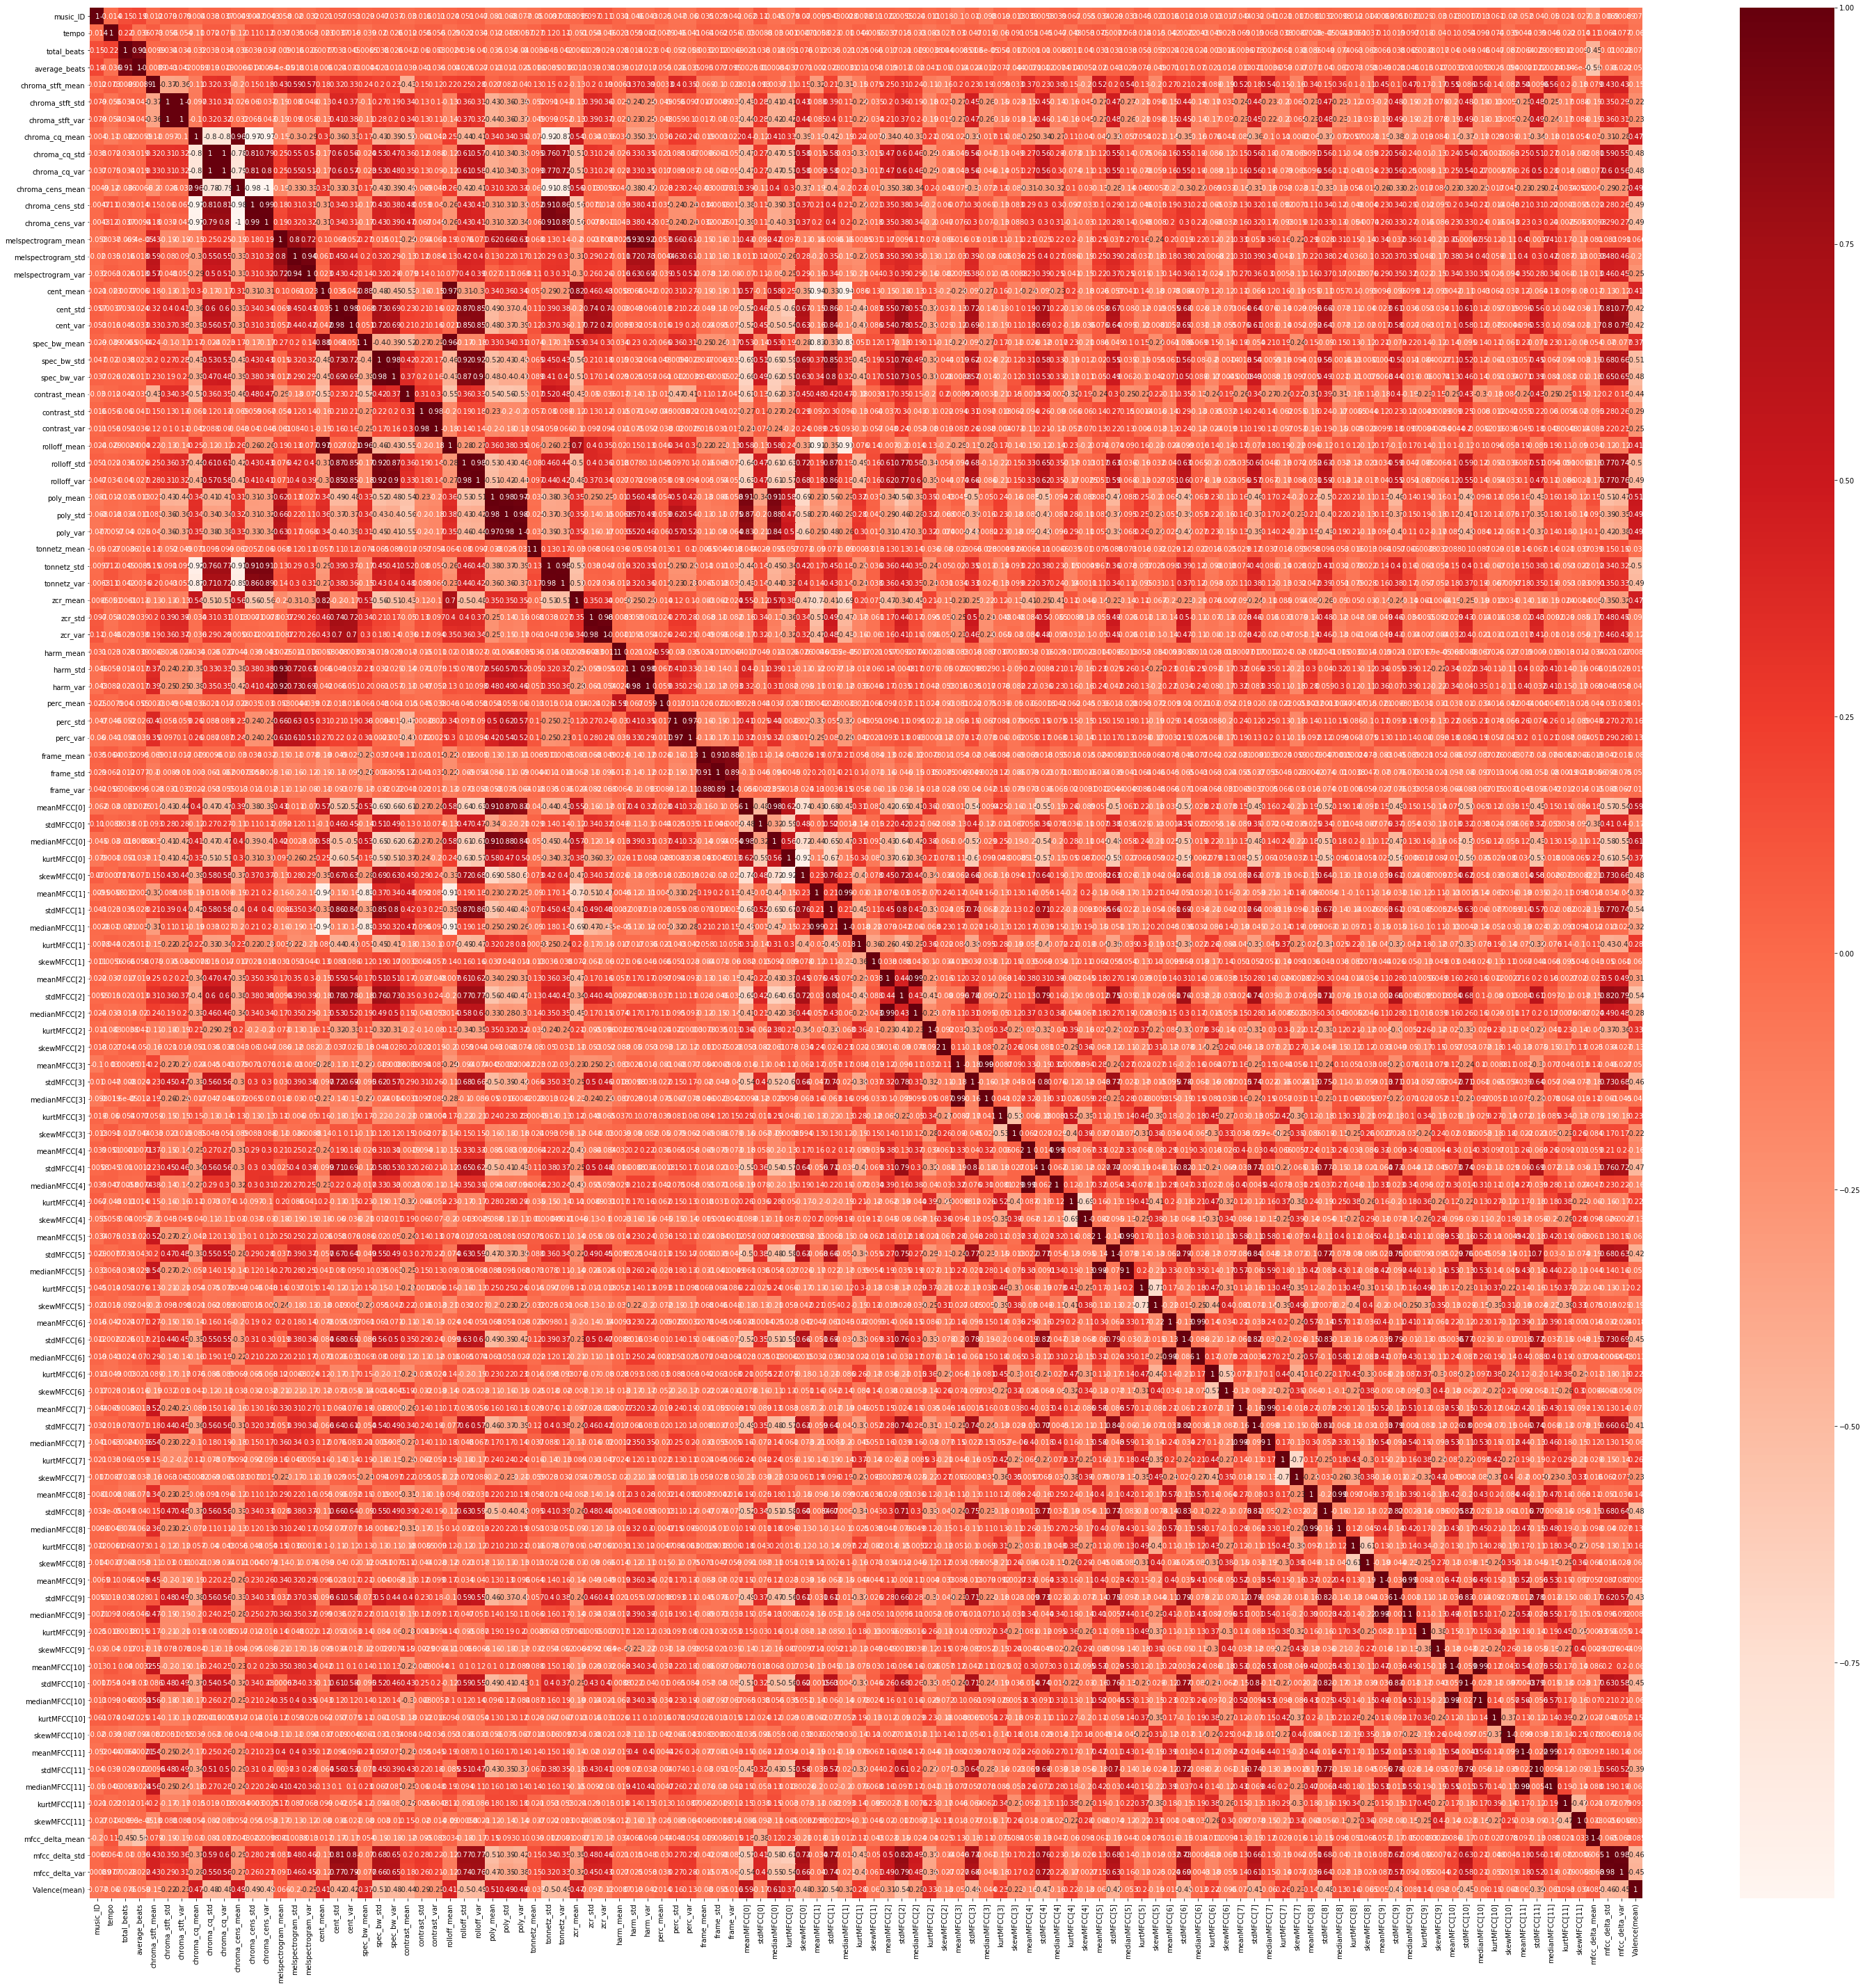

In [4]:
# The correlation coefficient has values between -1 to 1
# A value closer to 0 implies weaker correlation (exact 0 implying no correlation)
# A value closer to 1 implies stronger positive correlation
# A value closer to -1 implies stronger negative correlation

#static_v_mean = static_v_mean.drop(columns=['music_ID'])

plt.figure(figsize=(50,50))
cor = static_v_mean.corr()
sns.heatmap(cor, annot=True, cmap=plt.cm.Reds)
plt.show()

In [5]:
#Correlation with output variable

cor_target = abs(cor['Valence(mean)'])

#Selecting highly correlated features
relevant_features = cor_target[cor_target>0.5]
relevant_features

spec_bw_std      0.514848
poly_mean        0.512048
tonnetz_std      0.503954
meanMFCC[0]      0.593028
medianMFCC[0]    0.606916
stdMFCC[1]       0.541788
stdMFCC[2]       0.538732
Valence(mean)    1.000000
Name: Valence(mean), dtype: float64

In [8]:
pearson_list = relevant_features.axes
pearson_df = static_v_mean[np.intersect1d(static_v_mean.columns, pearson_list)]

pearson_df_a = pearson_df.drop(['Valence(mean)'], axis=1)

spec_bw_std      0.514848
poly_mean        0.512048
tonnetz_std      0.503954
meanMFCC[0]      0.593028
medianMFCC[0]    0.606916
stdMFCC[1]       0.541788
stdMFCC[2]       0.538732
Valence(mean)    1.000000
Name: Valence(mean), dtype: float64


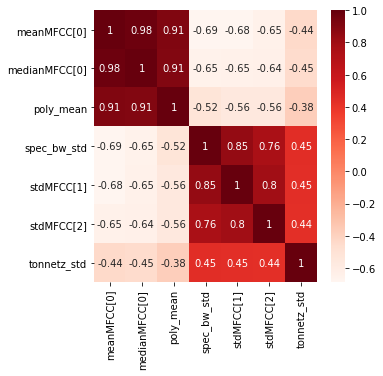

In [7]:
print(relevant_features)
plt.figure(figsize=(5,5))

cor = pearson_df.corr()
sns.heatmap(cor, annot=True, cmap=plt.cm.Reds)
plt.show()

In [24]:
pearson_df.head()

Valence(mean)  meanMFCC[0]  medianMFCC[0]  poly_mean  spec_bw_std  \
0         0.5750     0.642241       0.655402   0.299279     0.344950   
1         0.2875     0.537465       0.533510   0.362563     0.522508   
2         0.2000     0.520887       0.514163   0.311672     0.562045   
3         0.3500     0.620657       0.684476   0.417714     0.497836   
4         0.7250     0.796828       0.795002   0.551331     0.239343   

   stdMFCC[1]  stdMFCC[2]  tonnetz_std  
0    0.648016    0.390150     0.487728  
1    0.620699    0.529918     0.419663  
2    0.803440    0.692466     0.502788  
3    0.706077    0.664344     0.608879  
4    0.397390    0.238705     0.148882

# Backward elimination

In [26]:
# one iteration that found and remove the highest pvalue

#Adding constant column of ones, mandatory for sm.OLS model
X_1 = sm.add_constant(X)

#Fitting sm.OLS model
model = sm.OLS(y,X_1).fit()
print(model.pvalues)

const               0.431760
tempo               0.601358
total_beats         0.628700
average_beats       0.910409
chroma_stft_mean    0.262550
                      ...   
kurtMFCC[11]        0.408952
skewMFCC[11]        0.376661
mfcc_delta_mean     0.466536
mfcc_delta_std      0.021464
mfcc_delta_var      0.024961
Length: 109, dtype: float64


/Users/gioelepozzi/miniconda3/lib/python3.7/site-packages/numpy/core/fromnumeric.py:2542: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)


In [34]:
model.pvalues

const                  1.503598e-08
chroma_cq_mean         1.178195e-03
chroma_cq_std          1.880319e-02
chroma_cq_var          1.078829e-02
chroma_cens_mean       1.128383e-07
melspectrogram_mean    2.689379e-02
cent_mean              2.045630e-04
contrast_mean          3.953641e-03
contrast_std           3.293580e-02
tonnetz_std            1.684936e-02
tonnetz_var            2.160709e-02
harm_var               5.003698e-03
perc_std               2.241721e-03
frame_std              1.172305e-02
frame_var              1.691725e-02
meanMFCC[0]            2.001339e-15
stdMFCC[0]             6.128907e-05
skewMFCC[0]            3.544928e-02
medianMFCC[1]          7.279576e-07
skewMFCC[1]            3.116653e-05
meanMFCC[2]            1.603156e-02
medianMFCC[2]          4.386178e-03
stdMFCC[3]             1.041871e-02
medianMFCC[3]          2.085640e-02
skewMFCC[3]            1.353325e-03
kurtMFCC[4]            1.293951e-03
skewMFCC[4]            3.583275e-03
stdMFCC[5]             2.307

In [33]:
#Backward Elimination
cols = list(X.columns)
pmax = 1
while (len(cols)>0):
    p= []
    X_1 = X[cols]
    X_1 = sm.add_constant(X_1)
    model = sm.OLS(y,X_1).fit()
    p = pd.Series(model.pvalues.values[1:],index = cols)      
    pmax = max(p)
    feature_with_p_max = p.idxmax()
    if(pmax>0.05):
        cols.remove(feature_with_p_max)
    else:
        break
selected_features_BE = cols
print(selected_features_BE)

0.9903827858672918 medianMFCC[9]
0.9870350987531805 stdMFCC[6]
0.9792270887526386 poly_mean
0.9763569336012432 medianMFCC[0]
0.9439945754077492 chroma_cens_var
0.9144994772978279 perc_var
0.9119318498526231 average_beats
0.8979494678274507 stdMFCC[7]
0.8893819262996472 tonnetz_mean
0.8817418924964499 skewMFCC[7]
0.8681425015649211 melspectrogram_std
0.8801137129901885 rolloff_std
0.8609830479470348 stdMFCC[1]
0.8252511807522036 kurtMFCC[5]
0.8202316212716064 rolloff_mean
0.7461455567356621 skewMFCC[6]
0.7612490205626463 meanMFCC[5]
0.7608559981760069 spec_bw_mean
0.7910751555296596 rolloff_var
0.7432990689086165 perc_mean
0.7120114866262174 stdMFCC[4]
0.6765246040817681 kurtMFCC[9]
0.6545681053821153 skewMFCC[2]
0.6447413014203351 harm_mean
0.588971098287187 melspectrogram_var
0.5886239305382513 kurtMFCC[6]
0.5815741934856441 medianMFCC[11]
0.530859073665977 skewMFCC[10]
0.6352592466244786 meanMFCC[10]
0.5285280541740985 skewMFCC[9]
0.5115328246462083 tempo
0.5129757135016387 stdMFCC[1

In [10]:
backward_df = static_v_mean[np.intersect1d(static_v_mean.columns, selected_features_BE)]

In [11]:
backward_df.head()

cent_mean  chroma_cens_mean  chroma_cq_mean  chroma_cq_std  \
0  2874.357098          0.226653        0.401261       0.315778   
1  1754.980628          0.242035        0.455447       0.293067   
2  2209.346062          0.223880        0.398486       0.315170   
3  2511.312447          0.200098        0.334812       0.302933   
4  2713.926325          0.272532        0.584273       0.252345   

   chroma_cq_var  contrast_mean  contrast_std  frame_std  frame_var  harm_var  \
0       0.099715      21.357358      7.056910   1.363174   1.858242  0.017225   
1       0.085889      20.676389      7.409642   1.317973   1.737054  0.112057   
2       0.099332      20.725611      8.044129   0.919155   0.844845  0.072697   
3       0.091768      21.435182      7.932860   1.335567   1.783739  0.071636   
4       0.063678      20.252561      7.054508   1.500751   2.252254  0.031253   

   ...  skewMFCC[1]  skewMFCC[3]  skewMFCC[4]  skewMFCC[5]  stdMFCC[0]  \
0  ...     0.246240    -0.497022    -0.354608    -0.493410   70.369750   
1  ...    -0.333056    -0.361379    -0.196289    -0.818456   84.412970   
2  ...    -0.100528    -0.124900     0.026743    -0.324600   76.132590   
3  ...    -0.294355     0.756610    -0.178039    -0.243935  115.279520   
4  ...    -0.682530    -0.216047    -0.215887    -0.163493   56.604458   

   stdMFCC[3]  stdMFCC[5]  stdMFCC[8]  tonnetz_std  tonnetz_var  
0   18.221697   14.607980   13.788434     0.100549     0.010110  
1   23.422676   17.152494   14.236823     0.092003     0.008465  
2   20.977442   18.384447   14.336746     0.102440     0.010494  
3   27.453780   21.332376   13.315445     0.115761     0.013401  
4   15.859838   10.243058    8.761552     0.058003     0.003364  

[5 rows x 36 columns]

# Recursive Feature Elimination (RFE)

In [4]:
# RFE works by recursively removing attributes and building a model on those ones that remain
# accuracy metrics to rank. Gives the ranking of all the variables, 1 most important
# True as relevant feature, False for irrelevant features.

# here for a linear regression model with 7 features

model = LinearRegression()
#Initializing RFE model
rfe = RFE(model, 7)
#Transforming data using RFE
X_rfe = rfe.fit_transform(X,y)

#Fitting the data to model
model.fit(X_rfe,y)
print(rfe.support_)
print(rfe.ranking_)

[False False False False  True  True False False False False False False
 False False False False False False False False False False  True  True
 False False False False False False False False False False False False
 False False False False False False False False False  True False False
 False False False False False False False  True False  True False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False]
[ 91  64  97  27   1   1   7  25  26  36   6  89  14  65  84  17  37  38
  62  40  74  72   1   1  63  42  43  71  33  55 100  23  24  54   3   2
  73  11  10  78  15  93  39  19  18   1  56  99  57  46  16  95  44  75
  45   1  41   1  79  90   9  34   8  70  32  28  87  29  31  30  47  49
  48  94  61  13 102  12  88  92   4  98   5  69  

In [5]:
# now need to find the optimum number of features

#no of features
nof_list=np.arange(1,X.shape[1]) 
high_score=0
#Variable to store the optimum features
nof=0           
score_list =[]
for n in range(len(nof_list)):
    X_train, X_test, y_train, y_test = train_test_split(X,y, test_size = 0.3, random_state = 0)
    model = LinearRegression()
    rfe = RFE(model,nof_list[n])
    X_train_rfe = rfe.fit_transform(X_train,y_train)
    X_test_rfe = rfe.transform(X_test)
    model.fit(X_train_rfe,y_train)
    score = model.score(X_test_rfe,y_test)
    score_list.append(score)
    if(score>high_score):
        high_score = score
        nof = nof_list[n]

print("Optimum number of features: %d" %nof)
print("Score with %d features: %f" % (nof, high_score))

Optimum number of features: 24
Score with 24 features: 0.496128


In [6]:
# get the features selected with RFE

cols = list(X.columns)
model = LinearRegression()
#Initializing RFE model
rfe = RFE(model, nof)             
#Transforming data using RFE
X_rfe = rfe.fit_transform(X,y)  
#Fitting the data to model
model.fit(X_rfe,y)              
temp = pd.Series(rfe.support_,index = cols)
selected_features_rfe = temp[temp==True].index
print(selected_features_rfe)

Index(['chroma_stft_std', 'chroma_stft_var', 'chroma_cq_mean',
       'chroma_cens_std', 'melspectrogram_mean', 'cent_mean', 'contrast_std',
       'contrast_var', 'zcr_std', 'zcr_var', 'harm_std', 'harm_var',
       'perc_std', 'frame_var', 'meanMFCC[0]', 'meanMFCC[1]', 'meanMFCC[2]',
       'medianMFCC[2]', 'meanMFCC[3]', 'medianMFCC[3]', 'meanMFCC[6]',
       'medianMFCC[6]', 'meanMFCC[7]', 'medianMFCC[7]'],
      dtype='object')


In [15]:
rfe_df = static_v_mean[np.intersect1d(static_v_mean.columns, selected_features_rfe)]

In [16]:
rfe_df.head()

chroma_cens_mean  chroma_cens_std  chroma_cens_var  chroma_cq_mean  \
0          0.226653         0.178778         0.031962        0.401261   
1          0.242035         0.157328         0.024752        0.455447   
2          0.223880         0.182240         0.033211        0.398486   
3          0.200098         0.208073         0.043294        0.334812   
4          0.272532         0.095182         0.009060        0.584273   

   chroma_cq_std  chroma_cq_var  chroma_stft_mean  chroma_stft_std  \
0       0.315778       0.099715          0.400506         0.298598   
1       0.293067       0.085889          0.524068         0.286910   
2       0.315170       0.099332          0.541509         0.290565   
3       0.302933       0.091768          0.567836         0.253213   
4       0.252345       0.063678          0.390745         0.305108   

   chroma_stft_var  contrast_mean  ...  stdMFCC[5]  stdMFCC[7]  stdMFCC[8]  \
0         0.089161      21.357358  ...   14.607980   14.800909   13.788434   
1         0.082317      20.676389  ...   17.152494   16.560871   14.236823   
2         0.084428      20.725611  ...   18.384447   14.145410   14.336746   
3         0.064117      21.435182  ...   21.332376   14.487218   13.315445   
4         0.093091      20.252561  ...   10.243058    9.647967    8.761552   

   stdMFCC[9]  tonnetz_mean  tonnetz_std  tonnetz_var  zcr_mean   zcr_std  \
0   13.535014      0.013284     0.100549     0.010110  0.130466  0.087886   
1   14.680905      0.013740     0.092003     0.008465  0.035259  0.040965   
2   11.252135     -0.007431     0.102440     0.010494  0.067432  0.080143   
3   11.575115      0.024854     0.115761     0.013401  0.087807  0.064541   
4   10.107035      0.008147     0.058003     0.003364  0.129173  0.091938   

    zcr_var  
0  0.007724  
1  0.001678  
2  0.006423  
3  0.004166  
4  0.008453  

[5 rows x 91 columns]

# Embedded method

In [17]:
reg = LassoCV()
reg.fit(X, y)
print("Best alpha using built-in LassoCV: %f" % reg.alpha_)
print("Best score using built-in LassoCV: %f" %reg.score(X,y))
coef = pd.Series(reg.coef_, index = X.columns)

Best alpha using built-in LassoCV: 135.692170
Best score using built-in LassoCV: 0.255399


/Applications/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)


In [18]:
print("Lasso picked " + str(sum(coef != 0)) + " variables and eliminated the other " +  str(sum(coef == 0)) + " variables")

Lasso picked 5 variables and eliminated the other 103 variables


Text(0.5, 1.0, 'Feature importance using Lasso Model')

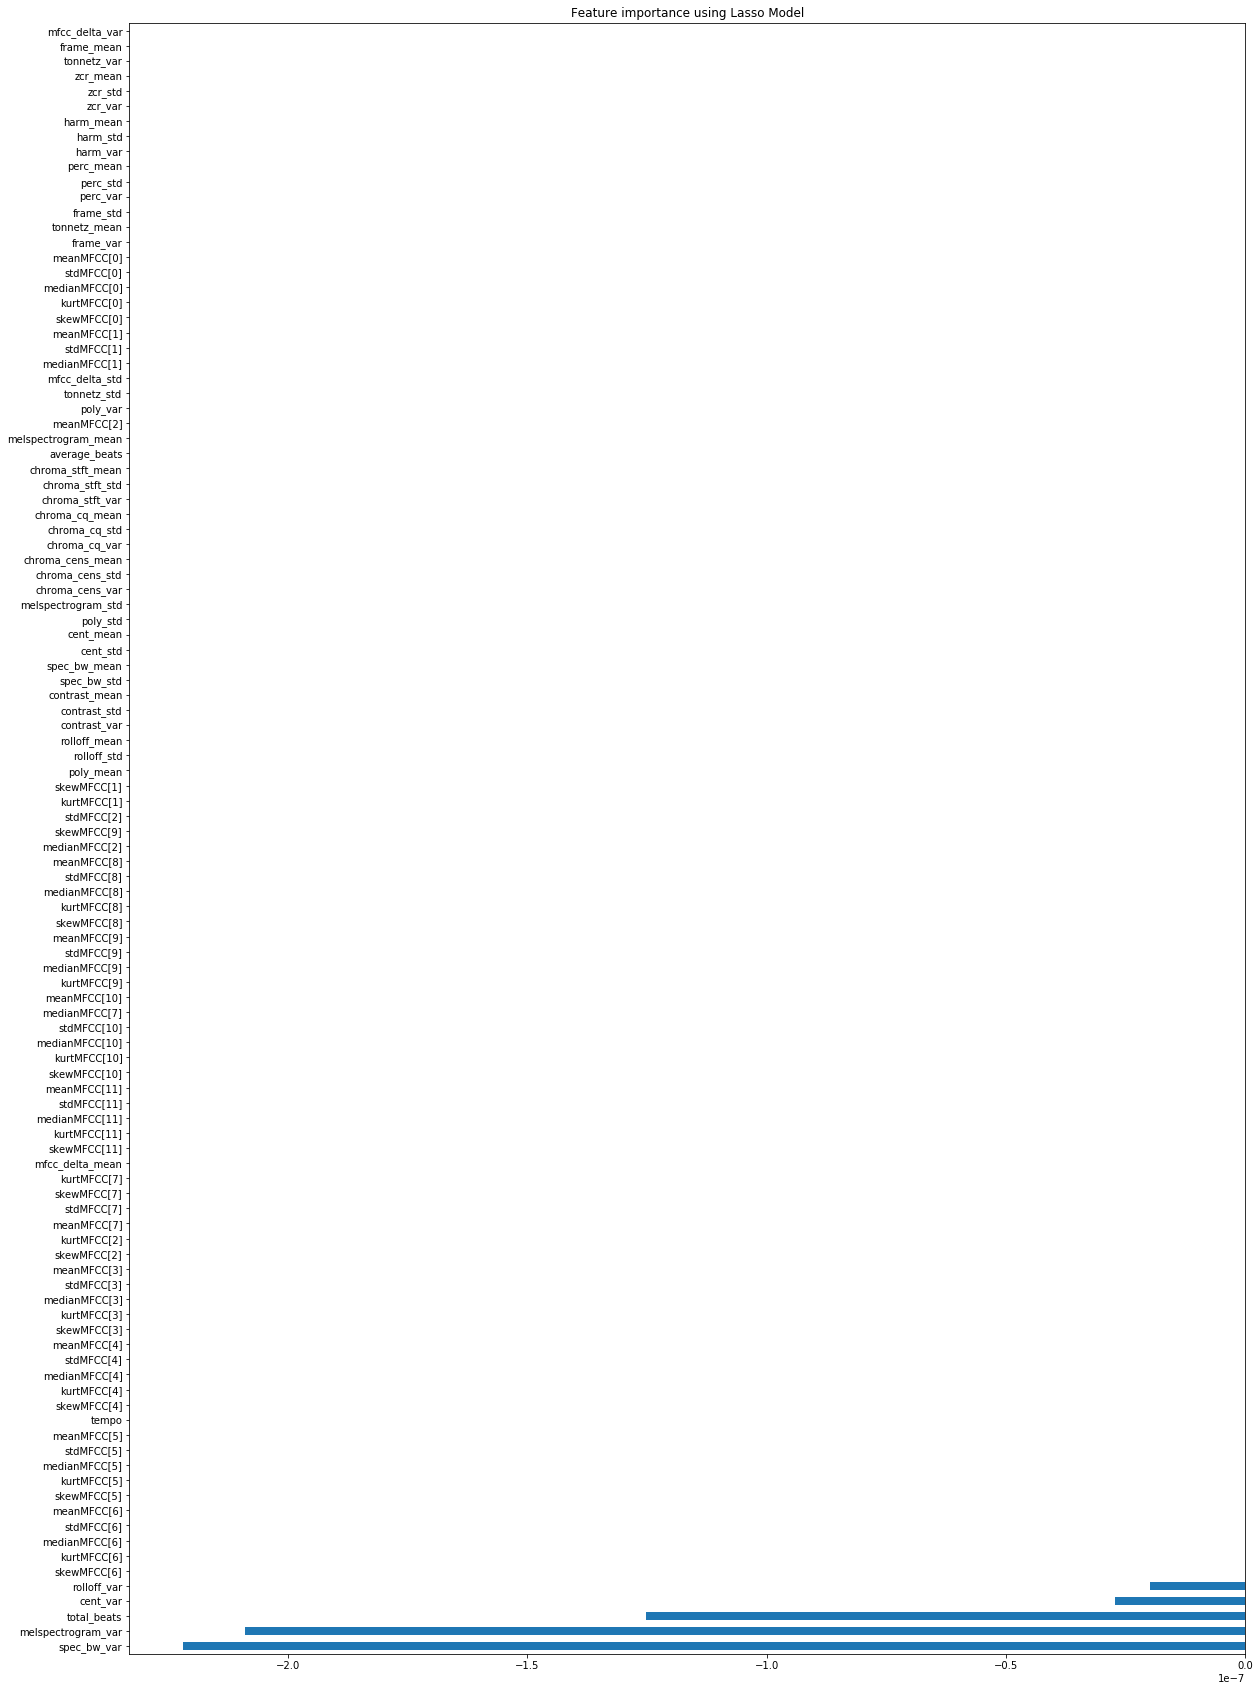

In [19]:
imp_coef = coef.sort_values()
import matplotlib
matplotlib.rcParams['figure.figsize'] = (20, 30)
imp_coef.plot(kind = "barh")
plt.title("Feature importance using Lasso Model")

In [20]:
embedded_list = imp_coef[imp_coef!=0].axes

embedded_df = static_v_mean[np.intersect1d(static_v_mean.columns, embedded_list)]

In [21]:
embedded_df.head()

cent_var  melspectrogram_var   rolloff_var    spec_bw_var  total_beats
0  1.204583e+06           2759.4133  3.628859e+06  228990.037873        45448
1  8.856171e+05          98252.1200  5.142861e+06  421925.917122        39347
2  1.640503e+06          55598.0430  6.092386e+06  472851.883537       346030
3  1.249683e+06          25732.6800  4.911973e+06  391617.967738        42339
4  9.463196e+05          12443.5060  2.436096e+06  141981.829089        31558

# RreliefF from skrebate

In [33]:
features, labels = X.values, y.values

clf = make_pipeline(ReliefF(n_features_to_select=2, n_neighbors=100),RandomForestClassifier(n_estimators=100))
#print('score:', np.mean(cross_val_score(clf, features, labels)))

X_train, X_test, y_train, y_test = train_test_split(features, labels)
fs = ReliefF()
fs.fit(X_train, y_train)

count = 0
for feature_name, feature_score in zip(X.columns,fs.feature_importances_):
    print(count, feature_name, feature_score)
    count = count+1
print('Order of most relevant features:\n', fs.top_features_)

0 tempo 0.004018749167201023
1 total_beats 0.005334825675074596
2 average_beats 0.005313506903336699
3 chroma_stft_mean 0.013180276795977053
4 chroma_stft_std 0.006942397971505937
5 chroma_stft_var 0.0074608217861345996
6 chroma_cq_mean 0.023300610754966495
7 chroma_cq_std 0.02264224725230369
8 chroma_cq_var 0.023085498498909965
9 chroma_cens_mean 0.02991742912742139
10 chroma_cens_std 0.03193341816617994
11 chroma_cens_var 0.03183184753594785
12 melspectrogram_mean 0.012930980038719045
13 melspectrogram_std 0.013298091562628917
14 melspectrogram_var 0.008511559621930807
15 cent_mean 0.026812036053325095
16 cent_std 0.02253624487331373
17 cent_var 0.018985894021731023
18 spec_bw_mean 0.022484554979589486
19 spec_bw_std 0.0212748724588584
20 spec_bw_var 0.014563242966045182
21 contrast_mean 0.025233077657812682
22 contrast_std 0.007602586218379084
23 contrast_var 0.005819491675055454
24 rolloff_mean 0.026187251167078974
25 rolloff_std 0.026753540251283184
26 rolloff_var 0.02228211069175

In [9]:
# function that returns the dataframes with the best 'max_features'-features
max_features = 10
features_array = fs.top_features_
best = features_array[:max_features]
df_best = static_v_mean.iloc[:,best]

df_best.head()

NameError: name 'fs' is not defined

# Function for feature selection

In [35]:
# target = 'Valence(mean)', 'Valence(std)', 'Arousal(mean)', 'Arousal(std)'
# selection_method = 'Pearson', 'backward', 'RFE', 'embedded', 'RreliefF'
# pearson_treshold = [0-1] value
# max_features = number of maximum features for RreliefF algorithm

def feature_sel(feature_dir, VA_dir, target, selection_method, pearson_treshold=0, max_features=0):
    feature_df = pd.read_csv(feature_dir)
    VA_df = pd.read_csv(VA_dir)
    VA_df = VA_df[['music_ID',target]]
    df = pd.merge(feature_df, VA_df, on=['music_ID'])
    
    X = df.drop(columns=['music_ID',target]) # feature matrix
    y = df[target] # target variable
    
    if selection_method == 'Pearson':
        
        cor = df.corr()
        cor_target = abs(cor[target])
        relevant_features = cor_target[cor_target>pearson_treshold]
        pearson_list = relevant_features.axes
        pearson_df = df[np.intersect1d(df.columns, pearson_list)]
        pearson_df = pearson_df.drop([target], axis=1)
        
        print('Relevant features with Pearson method where correlation is greater than ', pearson_treshold, ':\n', relevant_features)
        return pearson_df
    
    if selection_method == 'backward':
        
        cols = list(X.columns)
        pmax = 1
        while (len(cols)>0):
            p = []
            X_1 = X[cols]
            X_1 = sm.add_constant(X_1)
            model = sm.OLS(y,X_1).fit()
            p = pd.Series(model.pvalues.values[1:],index = cols)      
            pmax = max(p)
            feature_with_p_max = p.idxmax()
            if(pmax>0.05):
                cols.remove(feature_with_p_max)
            else:
                break
        selected_features_BE = cols
        backward_df = df[np.intersect1d(df.columns, selected_features_BE)]
        
        print('Relevant features with backward method:\n',selected_features_BE)
        return backward_df
    
    if selection_method == 'RFE':
        
        nof_list=np.arange(1,X.shape[1]) 
        high_score=0
        nof=0           
        score_list =[]
        for n in range(len(nof_list)):
            X_train, X_test, y_train, y_test = train_test_split(X,y, test_size = 0.3, random_state = 0)
            model = LinearRegression()
            rfe = RFE(model,nof_list[n])
            X_train_rfe = rfe.fit_transform(X_train,y_train)
            X_test_rfe = rfe.transform(X_test)
            model.fit(X_train_rfe,y_train)
            score = model.score(X_test_rfe,y_test)
            score_list.append(score)
            if(score>high_score):
                high_score = score
                nof = nof_list[n]

        cols = list(X.columns)
        model = LinearRegression()
        #Initializing RFE model
        rfe = RFE(model, nof)             
        #Transforming data using RFE
        X_rfe = rfe.fit_transform(X,y)  
        #Fitting the data to model
        model.fit(X_rfe,y)              
        temp = pd.Series(rfe.support_,index = cols)
        selected_features_rfe = temp[temp==True].index        
        rfe_df = df[np.intersect1d(df.columns, selected_features_rfe)]
        
        print('Relevant features with RFE method:\n', selected_features_rfe)
        return rfe_df
    
    if selection_method == 'embedded':
        
        reg = LassoCV()
        reg.fit(X, y)
        coef = pd.Series(reg.coef_, index = X.columns)
        imp_coef = coef.sort_values()
        embedded_list = imp_coef[imp_coef!=0].axes
        embedded_df = df[np.intersect1d(df.columns, embedded_list)]
        
        print('Relevant featues with embedded method:\n', embedded_list)
        return embedded_df
    
    if selection_method == 'RreliefF':
        
        features, labels = X.values, y.values
        clf = make_pipeline(ReliefF(n_features_to_select=2, n_neighbors=100),RandomForestClassifier(n_estimators=100))
        X_train, X_test, y_train, y_test = train_test_split(features, labels)
        fs = ReliefF()
        fs.fit(X_train, y_train)

        features_array = fs.top_features_
        best = features_array[:max_features]
        RreliefF_df = static_v_mean.iloc[:,best]
        
        print('Relevant features with RreliefF method:\n', best)
        return RreliefF_df


In [36]:
static_features_dir = '/Users/gioelepozzi/Desktop/data/features_thesis/static_features.csv'
VA_mean_dir = '/Users/gioelepozzi/Desktop/data/annotations_thesis/static_annotations.csv'

feature_sel(static_features_dir, VA_mean_dir, 'Valence(mean)', 'RreliefF', max_features=10)

Relevant features with RreliefF method:
 [11  9 47 10 27 29 28 51 45 56]


chroma_cens_std  chroma_cq_var  stdMFCC[0]  chroma_cens_mean  \
0           0.725570       0.855313    0.246567          0.451566   
1           0.600388       0.643463    0.342154          0.599986   
2           0.745772       0.849443    0.285793          0.424803   
3           0.896534       0.733550    0.552253          0.195338   
4           0.237698       0.303165    0.152871          0.894241   
..               ...            ...         ...               ...   
762         0.448252       0.586363    0.271564          0.745410   
763         0.349770       0.412732    0.461808          0.822009   
764         0.466383       0.492889    0.713486          0.729878   
765         0.280907       0.377421    1.000000          0.868192   
766         0.508830       0.428066    0.543379          0.691675   

     rolloff_var  poly_std  poly_mean  meanMFCC[1]  frame_var  meanMFCC[2]  
0       0.301386  0.340541   0.299279     0.293844   0.011696     0.466616  
1       0.441420  0.425011   0.362563     0.558708   0.010730     0.581269  
2       0.529243  0.384114   0.311672     0.428017   0.003613     0.684415  
3       0.420064  0.513633   0.417714     0.348852   0.011102     0.463738  
4       0.191065  0.621601   0.551331     0.389941   0.014839     0.491914  
..           ...       ...        ...          ...        ...          ...  
762     0.381625  0.602642   0.489471     0.342420   0.020068     0.490337  
763     0.125755  0.634771   0.589337     0.240599   0.014960     0.440727  
764     0.142806  0.648531   0.512020     0.213070   0.013614     0.499322  
765     0.116040  0.704087   0.586712     0.086111   0.008583     0.501272  
766     0.032847  0.714172   0.665616     0.133239   0.023956     0.496508  

[767 rows x 10 columns]